# AutoBacktest
Given a specific ticker, will return the backtest results of using Facebook Prophet as a trading strategy.

In [41]:
# Libraries
import pandas as pd
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import numpy as np
import plotly.express as px
from prophet import Prophet
import yfinance as yf
import itertools
import time
import random
from scipy import stats
from statsmodels.stats.weightstats import ztest

# Get Price Data

In [177]:
def getStockPrices(stock, n_days, training_days, mov_avg):
    """
    Gets stock prices from now to N days ago and training amount will be in addition 
    to the number of days to train.
    """
    
    # Designating the Ticker
    ticker = yf.Ticker(stock)

    # Getting all price history
    price_history = ticker.history(period="max")
    
    # Check on length
    if len(price_history)<n_days+training_days+mov_avg:
        return pd.DataFrame()
    
    # Getting relevant length
    prices = price_history.tail(n_days+training_days+mov_avg)
        
    # Filling NaNs with the most recent values for any missing data
    prices = prices.fillna(method='ffill')
    
    # Getting the N Day Moving Average and rounding the values for some light data preprocessing
    prices['MA'] = prices[['Close']].rolling(
        window=mov_avg
    ).mean().apply(lambda x: round(x, 2))

    # Resetting format for FBP
    prices = prices.reset_index().rename(
        columns={"Date": "ds", "MA": "y"}
    )
    
    # Dropping the Nans
    prices.dropna(inplace=True, subset=['y'])
    
    return prices, price_history

# Training Facebook Prophet

In [174]:
def fbpTrainPredict(df, forecast_period):
    """
    Uses FB Prophet and fits to a appropriately formatted DF. Makes a prediction N days into 
    the future based on given forecast period. Returns predicted values as a DF.
    """
    # Setting up prophet
    m = Prophet(
        daily_seasonality=True, 
        yearly_seasonality=True, 
        weekly_seasonality=True
    )
    
    # Fitting to the prices
    m.fit(df[['ds', 'y']])
    
    # Future DF
    future = m.make_future_dataframe(
        periods=forecast_period,
        freq='B',
        include_history=False
    )
            
    # Predicting values
    forecast = m.predict(future)

    # Returning a set of predicted values
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Using FBP

In [175]:
def runningFBP(prices, forecast_period, training_days):
    """
    Runs Facebook Prophet to get predictions over a set period 
    of time. Uses FBP to train and predict every N days and gets the 
    price forecasts.
    """
    # DF for the predicted values
    pred_df = pd.DataFrame()

    # Running the model each day
    for i in tqdm(range(training_days, len(prices)+1), leave=False):
        
        # Training and Predicting the last day on the forecast
        forecast = fbpTrainPredict(
            prices[i-training_days:i], 
            forecast_period
        ).tail(1)
        
        # Adding the forecast predicted
        pred_df = pred_df.append(forecast, ignore_index=True)
        
    # Prepping for merge by converting date values to be the same type
    pred_df['ds'] = pred_df['ds'].apply(lambda x: str(x)[:10])

    prices['ds'] = prices['ds'].apply(lambda x: str(x)[:10])
    
    # Shifting the forecasts back in order to compare it to the 'current' open values
    pred_df[['yhat', 'yhat_lower', 'yhat_upper']] = pred_df[['yhat', 'yhat_lower', 'yhat_upper']].shift(-forecast_period)
    
    # Merging with the prices DF in order to compare values for positions later
    merge_df = prices[['ds', 'Open']].merge(
        pred_df,
        on='ds',
        how='outer'
    ).dropna().set_index('ds')

    return merge_df

## Testing Functions

In [178]:
# Pricing Data Parameters
n_days = 60

training_days = 300

forecast_period = 5

mov_avg = 5

# Retrieving prices with the above parameters
prices, price_history = getStockPrices(
    "TSLA", 
    n_days=n_days,
    training_days=training_days,
    mov_avg=mov_avg
)

In [179]:
# Running Facebook Prophet with the set parameters
pred_df = runningFBP(
    prices, 
    forecast_period, 
    training_days
)

  0%|          | 0/62 [00:00<?, ?it/s]

# Getting Positions

In [106]:
def fbpPositions(pred_df, short=True):
    """
    Gets positions based on the predictions and the actual values.
    """
    if pred_df['Open'] < pred_df['yhat_lower']:
        return 1
    elif pred_df['Open'] > pred_df['yhat_upper'] and short:
        return -1
    else:
        return 0

## Testing Function Positions

In [107]:
# Adding sentiment positions to the forecast DF
positions = pred_df

# Getting forecast prophet positions
positions['fbp_positions'] = positions.apply(
    lambda x: fbpPositions(x, short=True), 
    axis=1
)

# Buy and hold position
positions['buy_hold'] = 1

# Backtest with Functions

In [108]:
# Getting daily returns
log_returns = prices[['ds', 'Close']].set_index(
    'ds'
).loc[positions.index].apply(np.log).diff()

In [109]:
# The positions to backtest (shifted ahead by 1 to prevent lookahead bias)
bt_positions = positions[[
    'buy_hold', 
    'fbp_positions'
]].shift(1)

# The returns during the backtest
returns = bt_positions.multiply(
    log_returns['Close'], 
    axis=0
)

# Inversing the log returns to get daily portfolio balance
performance = returns.cumsum().apply(
    np.exp
).dropna().fillna(
    method='ffill'
)

# Analyzing Backtest Performance

In [218]:
def riskAnalysis(performance, prices, price_history):
    """
    Analyzes the performance DataFrame to calculate various
    evaluation metrics on the backtest to determine if
    the backtest performance was favorable.
    """
    # Hypothesis testing average returns
    
    # Weekly returns for fb prophet
    rets = performance['fbp_positions'].pct_change(5).dropna()

    # Buy and hold for about the last two years for the stock
    hold = price_history['Close'].tail(500).apply(np.log).diff().cumsum().apply(np.exp).dropna()

    # Weekly returns in those years
    hold_ret = hold.pct_change(5).mean()

    # Average returns
    if len(performance)<=30:
        # T-testing
        stat_test = stats.ttest_1samp(
            rets, 
            popmean=hold_ret, 
            alternative='greater'
        )
    else:
        # Z-testing
        stat_test = ztest(
            rets, 
            value=hold_ret, 
            alternative='larger'
        )

    # Ending portfolio balance
    bal = performance.tail(1)
    
    # Moving Average returns
    ma_ret = performance.rolling(window=5).mean().dropna()
    
    # How often fbp beats holding
    ma_ret['diff'] = ma_ret['fbp_positions'] > ma_ret['buy_hold']
    
    diff = ma_ret['diff'].mean()

    # How often the fbp portfolio had a balance greater than its initial balance
    ma_ret['beat_bal'] = ma_ret['fbp_positions'] > 1
    
    beat_bal = ma_ret['beat_bal'].mean()
    
    # How often fbp MA returns were positive
    ma_ret['uptrend'] = ma_ret['fbp_positions'].diff().dropna()>=0
    
    uptrend = ma_ret['uptrend'].mean()
    
    # Performance score
    score = 0
    
    # P-value check
    if stat_test[1]<0.05:
        score += 1
    
    # Checking ending portfolio balance
    if bal['fbp_positions'][0]>bal['buy_hold'][0] and bal['fbp_positions'][0]>1: 
        score += 1
    
    # How often fbp outperformed buy and hold
    if diff>.8: 
        score += 1
        
    # How often fbp had returns greater than the initial portfolio balance
    if beat_bal>.6: 
        score += 1
        
    # How often fbp had positive upward trend
    if uptrend>.55:
        score += 1
        
    # Dictionary containing values
    score_res = {
        "result": True,
        "score": score,
        "endingBalance": {
            "prophet": bal['fbp_positions'][0],
            "buyHold": bal['buy_hold'][0]
        },
        "betterThanBuyHold": diff,
        "greaterPortfolioBalance": beat_bal,
        "upwardTrend": uptrend,
        "pValue": stat_test[1]
    }
    print("pVal: ", stat_test[1])
    if score>=5:
                
        return score_res
    
    else:
        # Backtest result is bad
        score_res['result'] = False
        
        return score_res

In [219]:
riskAnalysis(performance, prices, price_history)

pVal:  0.4877852679511954


{'result': False,
 'score': 4,
 'endingBalance': {'prophet': 1.1909396467423796,
  'buyHold': 1.0327510065899852},
 'betterThanBuyHold': 1.0,
 'greaterPortfolioBalance': 1.0,
 'upwardTrend': 0.673469387755102,
 'pValue': 0.4877852679511954}

# Visualization

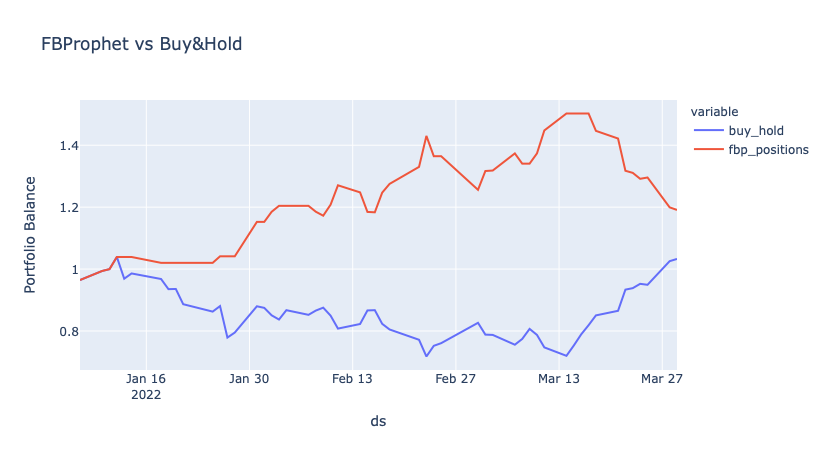

In [195]:
# Visualizing results
fig = px.line(
    performance,
    x=performance.index,
    y=performance.columns,
    title='FBProphet vs Buy&Hold',
    labels={"value": "Portfolio Balance",
            "index": "Date"}
)

fig.show()

# Consolidating Backtest Functions

In [200]:
def backtestStock(stock, pred_df, prices, price_history, last_res=False):
    
    # Adding positions to the forecast DF
    positions = pred_df

    # Getting forecast prophet positions 
    positions['fbp_positions'] = positions.apply(
        lambda x: fbpPositions(x, short=True), 
        axis=1
    )

    # Buy and hold position
    positions['buy_hold'] = 1
    
    # Getting daily returns
    log_returns = prices[['ds', 'Close']].set_index(
        'ds'
    ).loc[positions.index].apply(np.log).diff()
    
    # The positions to backtest (shifted ahead by 1 to prevent lookahead bias)
    bt_positions = positions[[
        'buy_hold', 
        'fbp_positions'
    ]].shift(1)

    # The returns during the backtest
    returns = bt_positions.multiply(
        log_returns['Close'], 
        axis=0
    )

    # Inversing the log returns to get daily portfolio balance
    performance = returns.cumsum().apply(
        np.exp
    ).dropna().fillna(
        method='ffill'
    )
    
    # Performing risk analysis
    risk = riskAnalysis(performance, prices, price_history)
    
    # Visualizing results
    if risk['result']==True or last_res==True:
        fig = px.line(
            performance,
            x=performance.index,
            y=performance.columns,
            title=f'FBProphet vs Buy&Hold for {stock}',
            labels={"value": "Portfolio Balance",
                    "index": "Date"}
        )

        fig.show()
                
    return risk

# Parameter Tuning

In [ ]:
def parameterTuning(stock, n_days_lst, training_days_lst, mov_avg_lst, forecast_period_lst, stop_early=True):
    """
    Given a list of parameters for a specific stock. Iterates through
    different combination of parameters until a successful backtest
    performance is found.
    
    Optional stop_early variable for stopping tuning immediately 
    when a positive backtest result is found
    """
    
    # Tuning the stock with FB Prophet
    print(f"Tuning FBP parameters for {stock}. . .")
    
    # All combinations of the parameters
    params = [n_days_lst, training_days_lst, mov_avg_lst, forecast_period_lst]
    
    lst_params = list(itertools.product(*params))
    
    # Randomizing order of params
    random.shuffle(lst_params)
    
    # List of tested params
    param_lst = []
    
    # Iterating through combos
    for param in tqdm(lst_params):

        # Retrieving prices with the given parameters
        prices, price_history = getStockPrices(
            stock, 
            n_days=param[0],
            training_days=param[1], 
            mov_avg=param[2]
        )

        # Checking if the prices retrieved are empty
        if prices.empty:
            print(f"Not enough price history for {stock}; skipping backtest...")
            continue

        # Running Facebook Prophet with the set parameters
        pred_df = runningFBP(
            prices, 
            forecast_period=param[3], 
            training_days=param[1]
        )

        # Running backtest
        if param==lst_params[-1]:
            backtest = backtestStock(stock, pred_df, prices, price_history, last_res=True)
        else:
            backtest = backtestStock(stock, pred_df, prices, price_history)
        
        # Creating param dictionary to record results
        res = {
            "n_days": param[0],
            "training_days": param[1],
            "mov_avg": param[2],
            "forecast_period": param[3],
            "backtestAnalysis": backtest
        }
        
        # Appending the results
        param_lst.append(res)
                
        # Checking backtest result
        if backtest['result']==True and stop_early==True:
                        
            return {
                "optimumParamLst": param_lst,
                "optimumResultFound": True
            }

    return {
        "optimumParamLst": sorted(
            param_lst,
            key=lambda x: (x['backtestAnalysis']['score'], x['backtestAnalysis']['pValue'])
        ),
        "optimumResultFound": False
    }

## Tuning Parameters

In [159]:
# Lists of different params to test
n_days_lst = [20, 40]

training_days_lst = [50,100,150]

mov_avg_lst = [3, 5]

forecast_period_lst = [3, 5]

# Using function to tune params
results = parameterTuning(
    "TSLA", 
    n_days_lst, 
    training_days_lst, 
    mov_avg_lst, 
    forecast_period_lst, 
    stop_early=True
)

Tuning FBP parameters for TSLA. . .


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Getting Stock and Backtest

In [202]:
def getStockAndBacktest(stock, n_days_lst, training_days_lst, mov_avg_lst, forecast_period_lst):
    
    # Printing the stock
    print(f"Backtesting {stock}. . .")

    # Tuning parameters for stock
    results = parameterTuning(
        stock, 
        n_days_lst, 
        training_days_lst, 
        mov_avg_lst, 
        forecast_period_lst, 
        stop_early=True
    )
    
    # Optimum Parameters
    opt_params = results['optimumParamLst'][-1]
    
    if results['optimumResultFound']==False:
        print(f"***No optimum params found for {stock}***")
    
    # Retrieving prices with the given parameters
    prices, price_history = getStockPrices(
        stock, 
        n_days=opt_params['n_days'],
        training_days=opt_params['training_days'], 
        mov_avg=opt_params['mov_avg']
    )
            
    # Run Prophet for current prediction
    preds = fbpTrainPredict(
        prices.tail(opt_params['training_days']), 
        opt_params['forecast_period']
    ).tail(1)

    preds['Open'] = prices.tail(1)['Open'].values

    # Getting forecast prophet positions
    trade_decision = fbpPositions(preds.to_dict('records')[0], short=True)

    trade_dict = {
        1 : f"Buy {stock}",
        0 : f"Exit {stock}/Do nothing",
        -1: f"Short {stock}"
    }

    # Printing trade decision
    print(trade_dict[trade_decision])
    
    # Printing the optimum params
    print("Best Optimum Parameters Found:\n", opt_params)

    return 

Backtesting JNJ. . .
Tuning FBP parameters for JNJ. . .


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

pVal:  0.9988145810862791


  0%|          | 0/22 [00:00<?, ?it/s]

pVal:  0.9966602023845357


  0%|          | 0/42 [00:00<?, ?it/s]

pVal:  0.657688272869076


  0%|          | 0/42 [00:00<?, ?it/s]

pVal:  0.9999995992993868


  0%|          | 0/22 [00:00<?, ?it/s]

pVal:  0.9616648760798474


  0%|          | 0/22 [00:00<?, ?it/s]

pVal:  0.9962891970400545


  0%|          | 0/22 [00:00<?, ?it/s]

pVal:  0.6591463643710669


  0%|          | 0/42 [00:00<?, ?it/s]

pVal:  0.9746018880552242


  0%|          | 0/22 [00:00<?, ?it/s]

pVal:  0.18773691351146304


  0%|          | 0/42 [00:00<?, ?it/s]

pVal:  0.9735497454661558


  0%|          | 0/42 [00:00<?, ?it/s]

pVal:  0.9051289831442728


  0%|          | 0/42 [00:00<?, ?it/s]

pVal:  0.1375601328882276


  0%|          | 0/22 [00:00<?, ?it/s]

pVal:  0.9613874261168986


  0%|          | 0/42 [00:00<?, ?it/s]

pVal:  0.008018005194468167


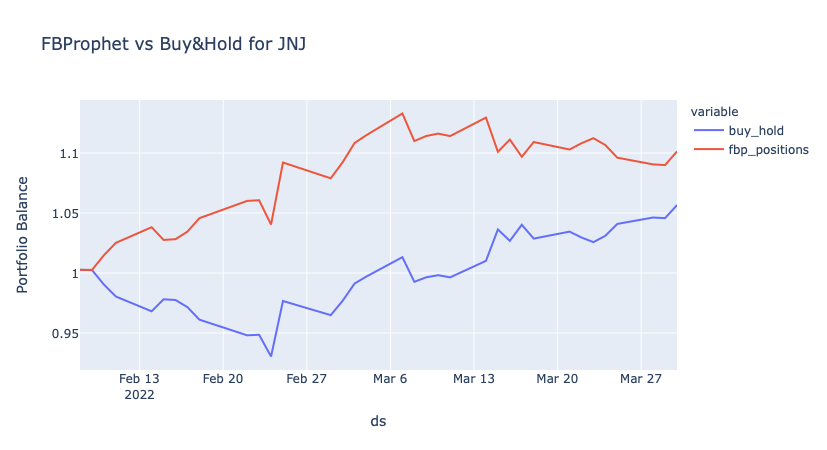

Buy JNJ
Best Optimum Parameters Found:
 {'n_days': 40, 'training_days': 200, 'mov_avg': 5, 'forecast_period': 5, 'backtestAnalysis': {'result': True, 'score': 5, 'endingBalance': {'prophet': 1.1013001182059639, 'buyHold': 1.0566048339342802}, 'betterThanBuyHold': 1.0, 'greaterPortfolioBalance': 1.0, 'upwardTrend': 0.6363636363636364, 'pValue': 0.008018005194468167}}
Backtesting MSFT. . .
Tuning FBP parameters for MSFT. . .


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

pVal:  0.8697047306143671


  0%|          | 0/42 [00:00<?, ?it/s]

pVal:  0.18732010956280148


  0%|          | 0/42 [00:00<?, ?it/s]

pVal:  0.9362313447373679


  0%|          | 0/22 [00:00<?, ?it/s]

pVal:  0.0027750978090966285


  0%|          | 0/42 [00:00<?, ?it/s]

pVal:  0.7841758702327704


  0%|          | 0/42 [00:00<?, ?it/s]

pVal:  0.8755435810338192


  0%|          | 0/22 [00:00<?, ?it/s]

pVal:  0.9780279235957167


  0%|          | 0/22 [00:00<?, ?it/s]

pVal:  0.7238888350065373


  0%|          | 0/22 [00:00<?, ?it/s]

pVal:  0.36539198487084945


  0%|          | 0/22 [00:00<?, ?it/s]

pVal:  0.9999591579814306


  0%|          | 0/22 [00:00<?, ?it/s]

pVal:  0.9113740401997511


  0%|          | 0/42 [00:00<?, ?it/s]

pVal:  0.19190144803835457


  0%|          | 0/22 [00:00<?, ?it/s]

pVal:  0.8863152911405268


  0%|          | 0/42 [00:00<?, ?it/s]

pVal:  0.029357394337471754


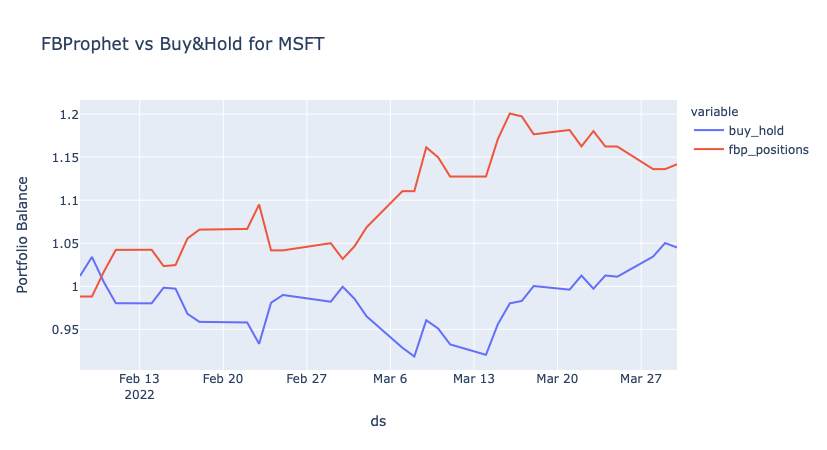

Short MSFT
Best Optimum Parameters Found:
 {'n_days': 40, 'training_days': 300, 'mov_avg': 5, 'forecast_period': 5, 'backtestAnalysis': {'result': True, 'score': 5, 'endingBalance': {'prophet': 1.1416743109702954, 'buyHold': 1.0450538405908805}, 'betterThanBuyHold': 0.9696969696969697, 'greaterPortfolioBalance': 0.9696969696969697, 'upwardTrend': 0.5757575757575758, 'pValue': 0.029357394337471754}}
Backtesting LMT. . .
Tuning FBP parameters for LMT. . .


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

pVal:  0.32491359020453037


  0%|          | 0/42 [00:00<?, ?it/s]

pVal:  0.10814456319742466


  0%|          | 0/42 [00:00<?, ?it/s]

pVal:  0.1313558423893071


  0%|          | 0/22 [00:00<?, ?it/s]

pVal:  0.46076254576409303


  0%|          | 0/22 [00:00<?, ?it/s]

pVal:  0.8816493433380272


  0%|          | 0/22 [00:00<?, ?it/s]

pVal:  0.24529329020915241


  0%|          | 0/42 [00:00<?, ?it/s]

pVal:  0.004653557636863787


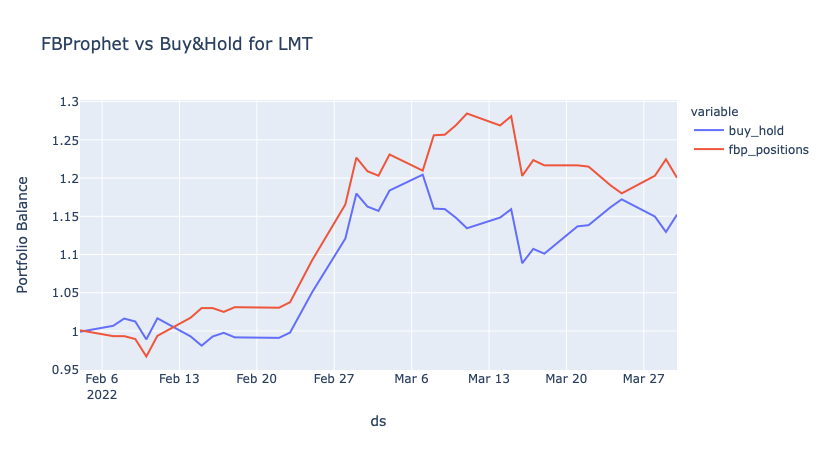

Short LMT
Best Optimum Parameters Found:
 {'n_days': 40, 'training_days': 50, 'mov_avg': 3, 'forecast_period': 3, 'backtestAnalysis': {'result': True, 'score': 5, 'endingBalance': {'prophet': 1.2003858500817157, 'buyHold': 1.1522203965913635}, 'betterThanBuyHold': 0.8571428571428571, 'greaterPortfolioBalance': 0.8571428571428571, 'upwardTrend': 0.7142857142857143, 'pValue': 0.004653557636863787}}
Backtesting DIS. . .
Tuning FBP parameters for DIS. . .


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

pVal:  1.0


  0%|          | 0/22 [00:00<?, ?it/s]

pVal:  0.04567339966803835


  0%|          | 0/42 [00:00<?, ?it/s]

pVal:  0.8597816687681711


  0%|          | 0/42 [00:00<?, ?it/s]

SystemError: <class 'stanfit4anon_model_dfdaf2b8ece8a02eb11f050ec701c0ec_7128984508780535170.PyStanHolder'> returned a result with an error set

In [208]:
# Lists of different params to test
n_days_lst = [20, 40]

training_days_lst = [50,100,200,300,400]

mov_avg_lst = [3,5]

forecast_period_lst = [3,5]

# List of stocks to backtest
tickers = ["MSFT", "JNJ", "DIS", "LMT", "GOOG"]

# Shuffling the stocks
random.shuffle(tickers)

for i in tickers:

    getStockAndBacktest(
        stock=i, 
        n_days_lst=n_days_lst, 
        training_days_lst=training_days_lst, 
        mov_avg_lst=mov_avg_lst,
        forecast_period_lst=forecast_period_lst
    )